## **Method of Unbiased Estimators**

Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.587147099958388
Epoch 200, Unbiased Loss: 0.5371641754779705
Epoch 300, Unbiased Loss: 0.5098997042844973
Epoch 400, Unbiased Loss: 0.49336232285072973
Epoch 500, Unbiased Loss: 0.48257118204266364
Epoch 600, Unbiased Loss: 0.47515747288895965
Epoch 700, Unbiased Loss: 0.46986941940560756
Epoch 800, Unbiased Loss: 0.4659897354593626
Epoch 900, Unbiased Loss: 0.4630806448508953
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5976751874765764
Epoch 200, Unbiased Loss: 0.5469571297183116
Epoch 300, Unbiased Loss: 0.5166821377479858
Epoch 400, Unbiased Loss: 0.49699328032974366
Epoch 500, Unbiased Loss: 0.4833890985874016
Epoch 600, Unbiased Loss: 0.47356691038203425
Epoch 700, Unbiased Loss: 0.46623742633556714
Epoch 800, Unbiased Loss: 0.460626454341045
Epoch 900, Unbiased Loss: 0.4562430204731075
Epoch 0, Unbiased Loss: 0.6931471805599452
Epoch 100, Unbiased Loss: 0.5974495519297007
Epoch 200, 

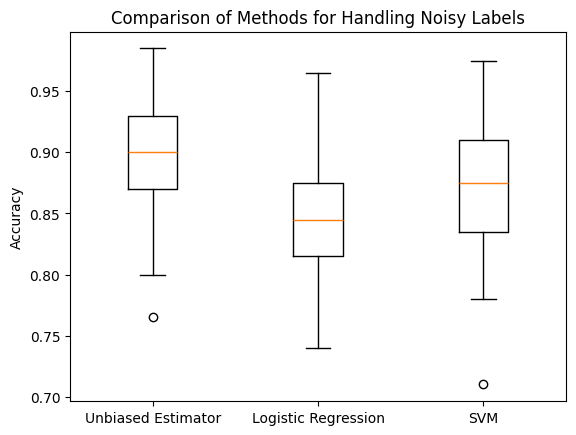

In [18]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=0, n_informative=2, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the Noise Transition Matrix
def define_noise_transition_matrix(noise_rate_positive, noise_rate_negative):
    T = np.array([[1 - noise_rate_negative, noise_rate_negative],
                  [noise_rate_positive, 1 - noise_rate_positive]])
    return T

# Unbiased logistic loss function
def unbiased_log_loss(y_true, y_pred, T):
    rho_minus = T[0, 1]
    rho_plus = T[1, 0]
    log_loss = np.logaddexp(0, -y_true * y_pred)
    log_loss_neg = np.logaddexp(0, y_true * y_pred)
    unbiased_loss = ((1 - rho_minus) * log_loss - rho_plus * log_loss_neg) / (1 - rho_plus - rho_minus)
    return np.mean(unbiased_loss)

# Logistic loss function and its gradient
def logistic_loss_and_grad(X, y, w):
    z = np.dot(X, w)
    loss = np.logaddexp(0, -y * z)
    grad = -y[:, np.newaxis] * X / (1 + np.exp(y * z))[:, np.newaxis]
    return np.mean(loss), np.mean(grad, axis=0)

# Custom training loop that minimizes the unbiased loss using gradient descent
def train_custom_logistic_regression(X, y, T, learning_rate=0.01, epochs=1000):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for epoch in range(epochs):
        z = np.dot(X, w)
        unbiased_loss_value = unbiased_log_loss(y, z, T)
        _, grad = logistic_loss_and_grad(X, y, w)
        w -= learning_rate * grad
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Unbiased Loss: {unbiased_loss_value}')
    return w

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, learning_rate=0.01, epochs=1000, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, y_test_noisy = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        T = define_noise_transition_matrix(noise_rate_positive, noise_rate_negative)
        
        # Train logistic regression with unbiased loss
        weights = train_custom_logistic_regression(X_train, y_train_noisy, T, learning_rate, epochs)
        y_pred_weighted_lr = np.sign(np.dot(X_test, weights))
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Train logistic regression without reweighting
        clf_logistic = LogisticRegression()
        clf_logistic.fit(X_train, y_train_noisy)
        y_pred_logistic = clf_logistic.predict(X_test)
        accuracy_logistic = accuracy_score(y_test_clean, y_pred_logistic)
        accuracies_unweighted_lr.append(accuracy_logistic)
        
        # Train SVM without reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Unbiased Estimator', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

## **Method of Label-dependent Costs**

*This method adjusts the cost (or weight) of different types of errors in the loss function to account for label noise.*

Weighted Logistic Regression - Mean accuracy: 0.8123, Standard deviation: 0.0793
Unweighted Logistic Regression - Mean accuracy: 0.7717, Standard deviation: 0.0801
SVM - Mean accuracy: 0.8946, Standard deviation: 0.0547


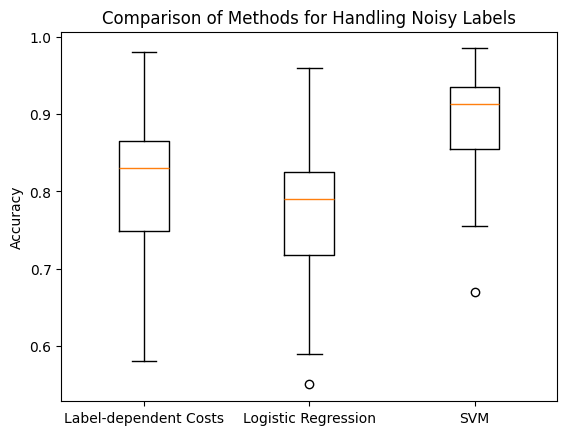

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)